##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Image Classification with Convolutional Neural Networks

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l04c01_image_classification_with_cnns.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l04c01_image_classification_with_cnns.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

このチュートリアルでは、ニューラルネットワークを構築およびトレーニングして、スニーカーやシャツなどの衣服の画像を分類します。

すべてを理解していなくても大丈夫です。 これは、完全なTensorFlowプログラムのペースの速い概要であり、途中で説明があります。 目標は、すべての詳細を把握するのではなく、TensorFlowプロジェクトの一般的な感覚をつかむことです。

このガイドでは、[tf.keras](https://www.tensorflow.org/guide/keras)、TensorFlowでモデルを構築およびトレーニングするための高レベルAPIを使用します。

## Install and import dependencies
[TensorFlow Datasets](https://www.tensorflow.org/datasets/)が必要になります。これは、データセットのダウンロードとアクセスを簡素化し、使用するサンプルデータセットを提供するAPIです。 また、いくつかのヘルパーライブラリも使用しています。

In [1]:
#from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
# try:
#   # Use the %tensorflow_version magic if in colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass

import tensorflow as tf

In [3]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Import the Fashion MNIST dataset

このガイドでは、[Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist)データセットを使用します。このデータセットには、10のカテゴリに70,000のグレースケール画像が含まれています。 画像は、ここに見られるように、低解像度（28 x 28ピクセル）で衣類の個々の記事を示しています。

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite" width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

ファッションMNISTは、古典的な[MNIST](http://yann.lecun.com/exdb/mnist/)データセットのドロップイン代替として意図されています。これは、コンピュータービジョンの機械学習プログラムの「Hello、World」としてよく使用されます 。 MNISTデータセットには、ここで使用する衣服と同じ形式の手書き数字（0、1、2など）の画像が含まれています。

このガイドでは、ファッションMNISTをさまざまに使用しています。これは、通常のMNISTよりもやや難しい問題だからです。 両方のデータセットは比較的小さく、アルゴリズムが期待どおりに機能することを確認するために使用されます。 これらは、コードをテストおよびデバッグするための良い出発点です。

60,000個の画像を使用してネットワークをトレーニングし、10,000個の画像を使用して、ネットワークが画像を分類するためにどれだけ正確に学習したかを評価します。 [データセット](https://www.tensorflow.org/datasets)APIを使用して、TensorFlowから直接ファッションMNISTにアクセスできます。

In [5]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

データセットをロードすると、メタデータと*トレーニングデータセット*および*テストデータセット*が返されます。

* モデルは `train_dataset`を使用してトレーニングされます。
* モデルは `test_dataset`に対してテストされます。

画像は28 x 28配列で、ピクセル値は `[0、255]`の範囲です。 *labels*は `[0、9]`の範囲の整数の配列です。 これらは、画像が表す服の*クラス*に対応します。

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

各画像は単一のラベルにマッピングされます。 *クラス名*はデータセットに含まれていないため、後で画像をプロットするときに使用するためにここに保存します。


In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

### Explore the data

モデルをトレーニングする前に、データセットの形式を調べてみましょう。 以下は、トレーニングセットに60,000個の画像があり、テストセットに10000個の画像があることを示しています。

In [7]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


## Preprocess the data

画像データの各ピクセルの値は、 `[0,255]`の範囲の整数です。 モデルが適切に機能するためには、これらの値を範囲`[0,1]`に正規化する必要があります。 したがって、ここでは正規化関数を作成し、テストおよびトレーニングデータセットの各画像に適用します。

In [8]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

### Explore the processed data

画像をプロットして、どのように見えるかを見てみましょう。

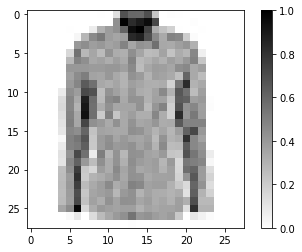

In [9]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

*トレーニングセット*の最初の25枚の画像を表示し、各画像の下にクラス名を表示します。 データが正しい形式であり、ネットワークを構築してトレーニングする準備ができていることを確認します。

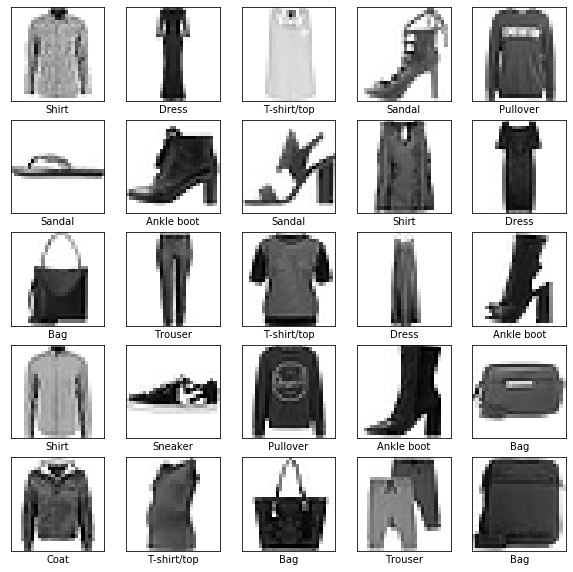

In [10]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

## Build the model

ニューラルネットワークを構築するには、モデルのレイヤーを構成してから、モデルをコンパイルする必要があります。

### Setup the layers

ニューラルネットワークの基本的な構成要素は*レイヤー*です。 レイヤーは、そこに入力されたデータから表現を抽出します。 うまくいけば、一連の接続されたレイヤーが、目前の問題にとって意味のある表現になることを願っています。

深層学習の多くは、単純なレイヤーを連結することで構成されています。 `tf.keras.layers.Dense`のようなほとんどのレイヤーには、トレーニング中に調整（「学習」）される内部パラメーターがあります。

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

このネットワーク層は次のとおりです。

* **"convolutions"** `tf.keras.layers.Conv2DおよびMaxPooling2D`— 2組のConv / MaxPoolでネットワークが開始されます。最初のレイヤーは、入力画像に適用されるConv2Dフィルター（3,3）で、パディングを使用して元の画像サイズを保持し、32の出力（畳み込み）画像を作成します（したがって、このレイヤーは、入力と同じサイズの32の畳み込み画像を作成します）。その後、32の出力のサイズは、ストライド2のMaxPooling2D（2,2）を使用して縮小されます。次のConv2Dには（3,3）カーネルもあり、32の画像を入力として、64の出力を作成します。 MaxPooling2Dレイヤーによりサイズが縮小されました。これまでのところ、畳み込みの機能について説明してきましたが、これらの複数を連結する方法についてはまだ説明していません。カラー画像を使用する場合、レッスン4でこれに戻ります。この時点で、畳み込みフィルターが実行する操作の種類を理解すれば十分です。

* **output** `tf.keras.layers.Dense` — 128ニューロンで、10ノードの*softmax*レイヤーが続きます。各ノードは衣服のクラスを表します。前のレイヤーと同様に、最後のレイヤーは、その前のレイヤーの128個のノードから入力を受け取り、画像がそのクラスに属する確率を表す「[0、1]」の範囲の値を出力します。 10個すべてのノード値の合計は1です。

### Compile the model

モデルのトレーニングの準備ができる前に、さらにいくつかの設定が必要です。 これらは、モデルの「コンパイル」ステップで追加されます。

* *Loss function(損失関数)* —モデルの出力が目的の出力からどれだけ離れているかを測定するためのアルゴリズム。 トレーニングの目標は、これが損失を測定することです。
* *Optimizer（最適化手法）* —損失を最小限に抑えるためにモデルの内部パラメーターを調整するアルゴリズム。
* *Metrics(評価方法)* —トレーニングおよびテスト手順を監視するために使用されます。 次の例では、正確に分類された画像の割合である*精度*を使用しています。

In [12]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model

最初に、トレインデータセットの反復動作を定義します。
1. `dataset.repeat（）`を指定して永久に繰り返します（以下で説明する `epochs`パラメーターはトレーニングの実行時間を制限します）。
2. `dataset.shuffle（60000）`は順序をランダム化するため、モデルは例の順序から何も学習できません。
3. そして、 `dataset.batch（32）`は、モデル変数を更新するときに32個の画像とラベルのバッチを使用するように `model.fit`に指示します。

トレーニングは `model.fit`メソッドを呼び出すことで実行されます：
1. `train_dataset`を使用してトレーニングデータをモデルにフィードします。
2. モデルは、画像とラベルの関連付けを学習します。
3. `epochs = 5`パラメーターは、トレーニングをトレーニングデータセットの5回の完全な反復に制限するため、合計5 * 60000 = 300000の例になります。

（ `steps_per_epoch`について心配する必要はありません。このフラグを設定する要件は間もなく削除されます。）

In [13]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [14]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Train for 1875 steps
Epoch 1/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.3985 - accuracy: 0.8568
Epoch 2/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.2546 - accuracy: 0.9068
Epoch 3/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.2112 - accuracy: 0.9236
Epoch 4/10
1875/1875 [==============================] - 35s 18ms/step - loss: 0.1798 - accuracy: 0.9337
Epoch 5/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.1536 - accuracy: 0.9430
Epoch 6/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.1304 - accuracy: 0.9509
Epoch 7/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.1107 - accuracy: 0.9590
Epoch 8/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0938 - accuracy: 0.9649
Epoch 9/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0790 - accuracy: 0.9710
Epoch 10/10
1875/1875 [====================

モデルが学習するにつれて、損失と精度のメトリックが表示されます。 このモデルは、トレーニングデータで約0.88（または88％）の精度に達します。

## Evaluate accuracy

次に、テストデータセットでモデルが実行する方法を比較します。 テストデータセットにあるすべての例を使用して、精度を評価します。

In [15]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 3s 8ms/step - loss: 0.2985 - accuracy: 0.9192
Accuracy on test dataset: 0.9192


結局のところ、テストデータセットの精度は、トレーニングデータセットの精度よりも小さくなっています。 モデルは「train_dataset」でトレーニングされているため、これは完全に正常です。 モデルがトレーニング中に見たことがない（つまり、 `test_dataset`から）画像を見ると、パフォーマンスが低下することが予想されます。

## Make predictions and explore

モデルをトレーニングしたら、それを使用していくつかの画像について予測を行うことができます。

In [16]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [17]:
predictions.shape

(32, 10)

ここで、モデルはテストセットの各画像のラベルを予測しています。 最初の予測を見てみましょう。

In [18]:
predictions[0]

array([6.7315827e-06, 1.2433479e-11, 1.9955743e-04, 1.5163801e-08,
       4.8146438e-02, 7.9292874e-09, 9.5164543e-01, 4.9476686e-08,
       6.4232281e-10, 1.7522375e-06], dtype=float32)

予測は10個の数字の配列です。 これらは、画像が10種類の衣類のそれぞれに対応しているというモデルの「自信」を表しています。 どのラベルの信頼度が最も高いかを確認できます。

In [19]:
np.argmax(predictions[0])

6

したがって、モデルは、この画像がシャツ、または「class_names [6]」であることを最も確信しています。 そして、テストラベルをチェックして、これが正しいことを確認できます。

In [20]:
test_labels[0]

6

これをグラフ化して、10クラスの予測の完全なセットを見ることができます。

In [21]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

0番目の画像、予測、予測配列を見てみましょう。

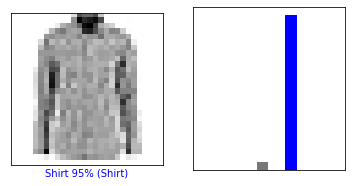

In [22]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

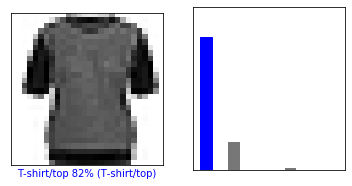

In [23]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

複数の画像とその予測をプロットしてみましょう。 正しい予測ラベルは青で、間違った予測ラベルは赤です。 この数値は、予測ラベルのパーセント（100のうち）を示します。 自信がある場合でも間違っている可能性があることに注意してください。

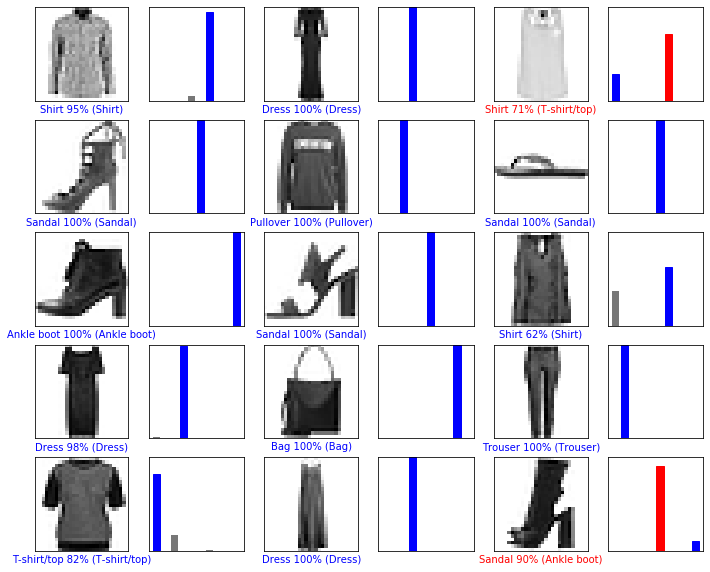

In [24]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


最後に、訓練されたモデルを使用して、単一の画像に関する予測を行います。

In [25]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


`tf.keras`モデルは、サンプルの*バッチ*またはコレクションの予測を一度に行うように最適化されています。 そのため、単一の画像を使用している場合でも、それをリストに追加する必要があります。

In [26]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


次に、画像を予測します。

In [27]:
predictions_single = model.predict(img)

print(predictions_single)

[[6.7316082e-06 1.2433479e-11 1.9955743e-04 1.5163860e-08 4.8146438e-02
  7.9293025e-09 9.5164543e-01 4.9476874e-08 6.4232525e-10 1.7522425e-06]]


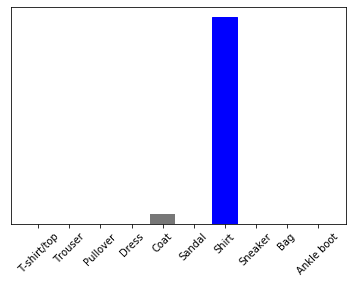

In [28]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

`model.predict`は、データのバッチ内の画像ごとに1つずつ、リストのリストを返します。 バッチ内の（唯一の）イメージの予測を取得します。

In [29]:
np.argmax(predictions_single[0])

6

そして、以前のように、モデルは6（シャツ）のラベルを予測します。

# Exercises

さまざまなモデルを試し、精度の結果がどのように異なるかを確認してください。 特に、次のパラメーターを変更します。
* トレーニングエポックを1に設定
* 平坦化層に続く密層のニューロン数。 たとえば、最大512の範囲で非常に低く（10など）、精度がどのように変化するかを確認します
* Flattenと最後のDense（10、activation = tf.nn.softmax）の間に追加の高密度レイヤーを追加し、これらのレイヤーの異なるユニットで実験します
* ピクセル値を正規化しないでください。

GPUを有効にして、すべてを高速に実行することを忘れないでください（ランタイム->ランタイムタイプの変更->ハードウェアアクセラレータ-> GPU）。
また、問題が発生した場合は、単に環境全体をリセットし、最初から始めます。
* 編集->すべての出力をクリア
* ランタイム->すべてのランタイムをリセット